In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_predict
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
df1 = pd.read_csv("frequency_domain_features_train.csv")
df2 = pd.read_csv("heart_rate_non_linear_features_train.csv")
df3 = pd.read_csv("time_domain_features_train.csv")

In [3]:
df1.shape, df2.shape, df3.shape

((369289, 12), (369289, 7), (369289, 20))

In [4]:
df4 = df1.merge(df2,how='inner',on='uuid')

In [5]:
df4.shape

(369289, 18)

In [6]:
df5 = df4.merge(df3,how='inner',on='uuid')

In [7]:
df5.shape

(369289, 37)

In [8]:
# RANDOM SAMPLE OF DATAFRAME
#df5 = df5.sample(50000)

In [9]:
df5.condition.nunique()

3

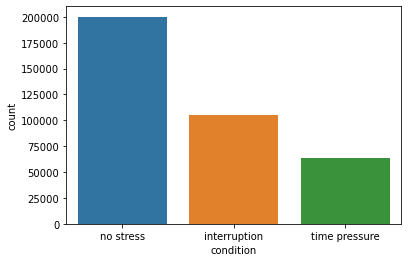

In [10]:
sns.countplot(df5["condition"])

In [11]:
conditions = [
    (df5['condition'] == "no stress"),
    (df5['condition'] == "interruption condition"),
    (df5['condition'] == "time pressure" )
    ]
values = [1,0,-1]
df5['condition2'] = np.select(conditions, values)

In [12]:
df6 = pd.read_csv("frequency_domain_features_test.csv")
df7 = pd.read_csv("heart_rate_non_linear_features_test.csv")
df8 = pd.read_csv("time_domain_features_test.csv")

In [13]:
df6.shape, df7.shape, df8.shape

((41033, 12), (41033, 7), (41033, 19))

In [14]:
df9 = df6.merge(df7,how='inner',on='uuid')
df10 = df9.merge(df8,how='inner',on='uuid')

In [15]:
conditions = [
    (df10['condition'] == "no stress"),
    (df10['condition'] == "interruption condition"),
    (df10['condition'] == "time pressure" )
    ]
values = [1,0,-1]
df10['condition2'] = np.select(conditions, values)

In [16]:
df10.shape

(41033, 37)

In [17]:
dftest = df10.drop(['uuid','condition','datasetId','SD1','SKEW_REL_RR','KURT_REL_RR',
                    'SDSD_REL_RR', 'SDRR', 'HF_NU','SDSD'], axis = 1)


In [18]:
dftrain = df5.drop(['uuid','condition','datasetId','SD1','SKEW_REL_RR','KURT_REL_RR',
                    'SDSD_REL_RR', 'SDRR', 'HF_NU','SDSD'], axis=1)

In [19]:
dftrain.head()

,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,TP,LF_HF,HF_LF,SD2,sampen,higuci,MEAN_RR,MEDIAN_RR,RMSSD,SDRR_RMSSD,HR,pNN25,pNN50,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDRR_RMSSD_REL_RR,condition2
0,2661.894136,72.203287,1009.249419,27.375666,98.485263,15.522603,0.421047,3686.666157,65.018055,0.015380,199.061782,2.139754,1.163485,885.157845,853.763730,15.554505,9.063146,69.499952,11.133333,0.533333,-0.856554,0.335218,-0.000203,-0.000179,0.017080,0.007969,2.143342,1
1,2314.265450,76.975728,690.113275,22.954139,99.695397,2.108525,0.070133,3006.487251,327.296635,0.003055,114.634458,2.174499,1.084711,939.425371,948.357865,12.964439,6.272369,64.363150,5.600000,0.000000,-0.408190,-0.155286,-0.000059,0.000611,0.013978,0.004769,2.930855,0
2,1373.887112,51.152225,1298.222619,48.335104,98.950472,13.769729,0.512671,2685.879461,94.280910,0.010607,118.939253,2.135350,1.176315,898.186047,907.006860,16.305279,5.182201,67.450066,13.066667,0.200000,0.351789,-0.656813,-0.000011,-0.000263,0.018539,0.008716,2.127053,0
3,2410.357408,70.180308,1005.981659,29.290305,98.224706,18.181913,0.529387,3434.520980,55.328701,0.018074,127.318597,2.178341,1.179688,881.757865,893.460030,15.720468,5.748591,68.809562,11.800000,0.133333,-0.504947,-0.386138,0.000112,0.000494,0.017761,0.008660,2.050988,1
4,1151.177330,43.918366,1421.782051,54.242160,96.720007,48.215822,1.839473,2621.175204,29.487873,0.033912,87.718281,2.221121,1.249612,809.625331,811.184865,19.213819,3.266724,74.565728,20.200000,0.200000,-0.548408,-0.154252,-0.000100,-0.002736,0.023715,0.013055,1.816544,1


In [20]:
dftest.head()

,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,TP,LF_HF,HF_LF,SD2,sampen,higuci,MEAN_RR,MEDIAN_RR,RMSSD,SDRR_RMSSD,pNN25,pNN50,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDRR_RMSSD_REL_RR,condition2
0,1868.532278,76.511189,570.643114,23.366245,99.478197,2.993254,0.122565,2442.168645,190.643094,0.005245,115.862444,2.209659,1.100715,934.665288,939.03173,11.801781,6.959924,3.933333,0.133333,-0.680262,-0.233075,0.000016,0.000288,0.012933,0.004578,2.825038,-1
1,568.742845,26.301350,1553.971621,71.862973,97.509212,39.694850,1.835677,2162.409316,39.147940,0.025544,77.118903,2.186132,1.290615,817.062380,816.33879,20.558810,2.699200,24.600000,0.533333,-0.034454,-0.051689,0.000040,-0.002749,0.025148,0.013921,1.806517,1
2,2101.871207,75.836461,655.175895,23.639042,97.829386,14.536877,0.524497,2771.583978,45.069921,0.022188,125.044377,2.051571,1.226663,876.762022,894.19889,13.853737,6.401942,7.066667,0.533333,-0.206953,-0.589940,0.000010,-0.000172,0.015533,0.008149,1.906180,1
3,5757.544433,90.562305,592.913021,9.326123,98.817806,7.093235,0.111572,6357.550689,83.588517,0.011963,302.029812,2.080910,1.085143,1038.640693,998.91429,16.457194,12.986774,10.800000,1.866667,-0.820407,0.487198,-0.000238,-0.000464,0.016882,0.007587,2.225116,-1
4,964.696325,70.256575,374.939530,27.305968,91.805057,33.468834,2.437457,1373.104689,11.202647,0.089265,72.579248,2.068728,1.252547,774.548508,778.90508,10.273114,5.020664,2.000000,0.066667,1.738453,-0.005082,0.000054,-0.000006,0.013479,0.007811,1.725606,0


In [21]:
dftrain.shape, dftest.shape

((369289, 28), (41033, 27))

In [22]:
df10.duplicated(subset='uuid').sum()

0

In [23]:
df5.duplicated(subset='uuid').sum()

0

In [24]:
X = dftrain.drop("HR",axis=1)
y = dftrain["HR"]

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=1)

In [26]:
X_train.shape, X_val.shape

((332360, 27), (36929, 27))

In [27]:
y_train.shape, y_val.shape

((332360,), (36929,))

In [28]:
#cp = dftrain.corr()
#mask = np.zeros_like(cp)
#mask[np.triu_indices_from(mask)] = True
#plt.figure(figsize=(30,30))
#with sns.axes_style("white"):
#    sns.heatmap(cp,annot=True,linewidth=2,mask = mask,cmap="coolwarm")
#plt.title("Correlation Plot")
#plt.show()

In [29]:
sc = StandardScaler()

X_train = pd.DataFrame(sc.fit_transform(X_train),columns=X.columns)
X_val = pd.DataFrame(sc.transform(X_val),columns=X.columns)

X_train.head()

,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,TP,LF_HF,HF_LF,SD2,sampen,higuci,MEAN_RR,MEDIAN_RR,RMSSD,SDRR_RMSSD,pNN25,pNN50,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDRR_RMSSD_REL_RR,condition2
0,-0.850461,-0.139308,-0.984299,0.123290,-0.183804,-0.404517,0.204009,-1.106199,-0.270674,0.126860,-0.739628,0.645106,0.332048,-0.158395,-0.087086,-1.207215,-0.424490,-1.054247,-0.874384,-0.548623,-0.319678,-0.556038,-0.446828,-1.121930,-0.724240,-0.523978,-1.797587
1,0.207041,-0.494574,1.859567,0.603678,0.948527,-0.631940,-0.786890,0.735448,0.206940,-0.878365,-0.043159,0.512342,0.642869,1.082557,1.114223,1.969545,-0.542877,2.435465,1.817293,-0.324967,-0.675614,-0.075092,-0.923057,0.908367,0.478176,0.072576,-0.484008
2,3.465601,1.503677,-0.020234,-1.511359,-0.388739,0.458113,-0.557876,3.276715,-0.278136,0.319469,2.597732,-0.637816,-1.277965,0.611599,0.246970,0.633437,1.986375,0.336757,1.750001,-0.882233,0.591298,-0.544726,0.736833,0.827142,0.541158,-0.139616,0.829571
3,-0.070555,-0.218677,0.513966,0.139282,-0.803162,1.430990,0.814190,0.120531,-0.288248,0.719753,0.567114,0.025691,0.273998,-0.399367,-0.155129,0.638723,0.252095,0.255412,1.211666,-1.041454,-0.297102,0.103730,-0.029783,1.110613,1.349639,-0.959245,0.829571
4,0.081083,0.875895,-0.574053,-0.831399,0.777681,-0.695688,-0.770841,-0.111165,-0.098269,-0.732786,-0.367277,-0.022202,-1.292749,0.370264,0.437421,-0.542377,-0.203448,-0.484830,-0.605217,0.209012,-0.781857,-0.685079,0.625590,-0.755545,-1.037874,1.456332,0.829571


In [30]:
#param_grid = {'alpha': np.arange(0,2,0.05)}
#
#grid_tree = GridSearchCV(Lasso(), param_grid ,cv=10, scoring= 'neg_mean_absolute_error')
#grid_tree.fit(X_train, y_train)
#print(grid_tree.best_estimator_)
#print(np.abs(grid_tree.best_score_))

In [31]:
# linear regression
lr = LinearRegression()


# fit models on training data 
lr.fit(X_train, y_train)

# make predictions on test data
y_pred_lr = lr.predict(X_val)

# calculate preformance measures linear regression
rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr))
mse_lr = mean_squared_error(y_val, y_pred_lr)
mae_lr = mean_absolute_error(y_val, y_pred_lr)
r2_lr = r2_score(y_val, y_pred_lr)
adjr2_lr = 1-(1-r2_lr)*(len(y_val)-1)/(len(y_val)-len(X_val.columns)-1)

In [32]:
resultsDf1 = pd.DataFrame({'Method':['Linear Regression'], 'RMSE': rmse_lr , 'MSE': mse_lr , 'MAE': mae_lr ,"R2": r2_lr, 'Adj_R2': adjr2_lr})
resultsDf1

,Method,RMSE,MSE,MAE,R2,Adj_R2
0,Linear Regression,1.418821,2.013052,0.949578,0.981004,0.98099


In [33]:
#linear_coef = pd.DataFrame()
#linear_coef['linear_Col'] = X_train.columns
#linear_coef['linear_Coeff'] = abs(np.round((lr.coef_),3))
#linear_coef.sort_values(by='linear_Coeff',ascending=False).head(33)

In [34]:
# lasso regression
lasso = Lasso(alpha = 0.0)

# fit lasso on training data
lasso.fit(X_train, y_train)

# make prediciton on test data
y_pred_lasso = lasso.predict(X_val)

In [35]:
# calculate preformance measures lasso regression
rmse_lasso = np.sqrt(mean_squared_error(y_val, y_pred_lasso))
mse_lasso = mean_squared_error(y_val, y_pred_lasso)
mae_lasso = mean_absolute_error(y_val, y_pred_lasso)
r2_lasso = r2_score(y_val, y_pred_lasso)
adjr2_lasso = 1-(1-r2_lasso)*(len(y_val)-1)/(len(y_val)-len(X_val.columns)-1)


In [36]:
resultsDf2 = pd.DataFrame({'Method':['Lasso Regression'], 'RMSE': rmse_lasso , 'MSE': mse_lasso , 'MAE': mae_lasso ,"R2": r2_lasso, 'Adj_R2': adjr2_lasso})
resultsDf2

,Method,RMSE,MSE,MAE,R2,Adj_R2
0,Lasso Regression,1.418689,2.012677,0.949435,0.981008,0.980994


In [37]:
#lasso_coef = pd.DataFrame()
#lasso_coef['lasso_Col'] = X_train.columns
#lasso_coef['lasso_Coeff'] = abs(np.round((lasso.coef_),3))
#lasso_coef.sort_values(by='lasso_Coeff',ascending=False).head(33)

In [38]:
# ridge regression
ridge = Ridge(alpha = 1.95)

# fit ridge on training data
ridge.fit(X_train, y_train)

# make prediciton on test data
y_pred_ridge = ridge.predict(X_val)

In [39]:
# calculate preformance measures ridge regression
rmse_ridge = np.sqrt(mean_squared_error(y_val, y_pred_ridge))
mse_ridge = mean_squared_error(y_val, y_pred_ridge)
mae_ridge = mean_absolute_error(y_val, y_pred_ridge)
r2_ridge = r2_score(y_val, y_pred_ridge)
adjr2_ridge = 1-(1-r2_ridge)*(len(y_val)-1)/(len(y_val)-len(X_val.columns)-1)

resultsDf3 = pd.DataFrame({'Method':['Ridge Regression'], 'RMSE': rmse_ridge , 'MSE': mse_ridge , 'MAE': mae_ridge ,"R2": r2_ridge, 'Adj_R2': adjr2_ridge})
resultsDf3

,Method,RMSE,MSE,MAE,R2,Adj_R2
0,Ridge Regression,1.418801,2.012996,0.949477,0.981005,0.980991


In [40]:
#ridge_coef = pd.DataFrame()
#ridge_coef['ridge_Col'] = X_train.columns
#ridge_coef['ridge_Coeff'] = abs(np.round((ridge.coef_),3))
#ridge_coef.sort_values(by='ridge_Coeff',ascending=False).head(33)

In [41]:
linear = pd.concat([resultsDf1, resultsDf2, resultsDf3],axis=0)
linear

,Method,RMSE,MSE,MAE,R2,Adj_R2
0,Linear Regression,1.418821,2.013052,0.949578,0.981004,0.980990
0,Lasso Regression,1.418689,2.012677,0.949435,0.981008,0.980994
0,Ridge Regression,1.418801,2.012996,0.949477,0.981005,0.980991


In [43]:
#pd.concat([linear_coef, lasso_coef, ridge_coef],axis=1)

In [44]:
#Residual plots

#for i in ['VLF', 'VLF_PCT', 'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'TP',
#       'LF_HF', 'HF_LF', 'SD2', 'sampen', 'higuci', 'MEAN_RR', 'MEDIAN_RR',
#       'RMSSD', 'SDRR_RMSSD', 'pNN25', 'pNN50', 'KURT', 'SKEW', 'MEAN_REL_RR',
#       'MEDIAN_REL_RR', 'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDRR_RMSSD_REL_RR',
#       'condition2']:
#    fig = plt.figure(figsize=(10,8))
#    sns.residplot(x= X_val[i], y= y_val, color='green', lowess=True )

In [45]:
rf=RandomForestRegressor(random_state=1, n_estimators=20, max_depth=50)
rf.fit(X_train,y_train)
#rf.score(X_train,y_train)

#this line doesn't make sense to me
y_pred_rf_train=rf.predict(X_train)
#

y_pred_rf_val=rf.predict(X_val)
print('Train R2 score: ', r2_score(y_train,y_pred_rf_train))
print('Validation R2 score: ', r2_score(y_val,y_pred_rf_val))

Train R2 score:  0.9999985183182631
Validation R2 score:  0.9999912482134314


In [46]:
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf_val))
mse_rf = mean_squared_error(y_val, y_pred_rf_val)
mae_rf = mean_absolute_error(y_val, y_pred_rf_val)
r2_rf = r2_score(y_val, y_pred_rf_val)
adjr2_rf = 1-(1-r2_rf)*(len(y_val)-1)/(len(y_val)-len(X_val.columns)-1)

resultsDf1 = pd.DataFrame({'Method':['Random Forest'], 'RMSE': rmse_rf , 'MSE': mse_rf , 'MAE': mae_rf ,"R2": r2_rf, 'Adj_R2': adjr2_rf})
resultsDf1

,Method,RMSE,MSE,MAE,R2,Adj_R2
0,Random Forest,0.030454,0.000927,0.007101,0.999991,0.999991


In [47]:
#This block doesn't make sense to me

rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_rf_train))
mse_rf = mean_squared_error(y_train, y_pred_rf_train)
mae_rf = mean_absolute_error(y_train, y_pred_rf_train)
r2_rf = r2_score(y_train, y_pred_rf_train)
adjr2_rf = 1-(1-r2_rf)*(len(y_train)-1)/(len(y_train)-len(X_train.columns)-1)

resultsDf1 = pd.DataFrame({'Method':['Random Forest'], 'RMSE': rmse_rf , 'MSE': mse_rf , 'MAE': mae_rf ,"R2": r2_rf, 'Adj_R2': adjr2_rf})
resultsDf1
#

,Method,RMSE,MSE,MAE,R2,Adj_R2
0,Random Forest,0.012589,0.000158,0.003191,0.999999,0.999999


In [48]:
#rf_coef = pd.DataFrame()
#rf_coef['rf_Col'] = X_train.columns
#rf_coef['rf_Coeff'] = abs(np.round((rf.feature_importances_),5))
#rf_coef.sort_values(by='rf_Coeff',ascending=False)

In [49]:
# Gradient Boost


In [50]:

gb=GradientBoostingRegressor(random_state=1,n_estimators=50 ,max_depth=50,learning_rate=.1)
gb.fit(X_train,y_train)
#gb.score(X_train,y_train)
y_pred_gbtr=gb.predict(X_train)
y_pred_gbval=gb.predict(X_val)
print('Train R2 score: ',r2_score(y_train,y_pred_gbtr))
print('Test R2 score: ',r2_score(y_val,y_pred_gbval))

Train R2 score:  0.9999734386011124
Test R2 score:  0.9999295694376167


In [51]:
rmse_gb = np.sqrt(mean_squared_error(y_val, y_pred_gbval))
mse_gb = mean_squared_error(y_val, y_pred_gbval)
mae_gb = mean_absolute_error(y_val, y_pred_gbval)
r2_gb = r2_score(y_val, y_pred_gbval)
adjr2_gb = 1-(1-r2_gb)*(len(y_val)-1)/(len(y_val)-len(X_val.columns)-1)


resultsDf2 = pd.DataFrame({'Method':['Gradient Boost'], 'RMSE': rmse_gb , 'MSE': mse_gb , 'MAE': mae_gb ,"R2": r2_gb, 'Adj_R2': adjr2_gb})
resultsDf2

,Method,RMSE,MSE,MAE,R2,Adj_R2
0,Gradient Boost,0.086393,0.007464,0.044539,0.99993,0.99993


In [52]:
#AdaBoostRegressor

In [53]:
ab = AdaBoostRegressor(n_estimators = 15, random_state = 1)
ab.fit(X_train, y_train)
ab_pred = ab.predict(X_val)

print('AdaBoost Regressor:')
print('')
print('Training Score:', ab.score(X_train, y_train))
print('Validate Score:', ab.score(X_val, y_val))



rmse_ab = np.sqrt(mean_squared_error(y_val, ab_pred))
mse_ab = mean_squared_error(y_val, ab_pred)
mae_ab = mean_absolute_error(y_val, ab_pred)
r2_ab = r2_score(y_val, ab_pred)
adjr2_ab = 1-(1-r2_ab)*(len(y_val)-1)/(len(y_val)-len(X_val.columns)-1)

print('Root Mean Sq Error:', rmse_ab)
print('Mean Sq Error:', mse_ab)
print('Mean Abs Error:', mae_ab)
print('R2:', r2_ab)
print('Adj R2:', adjr2_ab)

AdaBoost Regressor:

Training Score: 0.9756740580889769
Validate Score: 0.9755760352965355
Root Mean Sq Error: 1.6088182614905226
Mean Sq Error: 2.5882961985053874
Mean Abs Error: 1.2815362314916658
R2: 0.9755760352965355
Adj R2: 0.975558164587151


In [54]:
#StackingRegressor
estimators = [('bagging',BaggingRegressor()),('adaboost',AdaBoostRegressor()),('gradboost',GradientBoostingRegressor())]


In [55]:
sr = StackingRegressor(estimators = estimators, final_estimator = RandomForestRegressor(n_estimators = 10, random_state = 1))
sr.fit(X_train, y_train)
sr_pred = sr.predict(X_val)

print('Stacking Regressor:')
print('')
print('Training Score:', sr.score(X_train, y_train))
print('Validate Score:', sr.score(X_val, y_val))



rmse_sr = np.sqrt(mean_squared_error(y_val, sr_pred))
mse_sr = mean_squared_error(y_val, sr_pred)
mae_sr = mean_absolute_error(y_val, sr_pred)
r2_sr = r2_score(y_val, sr_pred)
adjr2_sr = 1-(1-r2_sr)*(len(y_val)-1)/(len(y_val)-len(X_val.columns)-1)

print('Root Mean Sq Error:', rmse_sr)
print('Mean Sq Error:', mse_sr)
print('Mean Abs Error:', mae_sr)
print('R2:', r2_sr)
print('Adj R2:', adjr2_sr)

Stacking Regressor:

Training Score: 0.9999931301087759
Validate Score: 0.9999825722941914
Root Mean Sq Error: 0.04297530973747124
Mean Sq Error: 0.00184687724703159
Mean Abs Error: 0.011979908485572172
R2: 0.9999825722941914
Adj R2: 0.9999825595425571


In [56]:
# creating a new dataframe of predictions, last column is true values
columns = [y_pred_lr, y_pred_lasso, y_pred_ridge, y_pred_rf_val, y_pred_gbval, ab_pred, sr_pred, y_val]
predictions = pd.DataFrame({'y_pred_lr': y_pred_lr, 'y_pred_lasso': y_pred_lasso,
                            'y_pred_ridge': y_pred_ridge, 'y_pred_rf_val': y_pred_rf_val,
                            'y_pred_gbval': y_pred_gbval, 'ab_pred': ab_pred, 'sr_pred': sr_pred,
                            'sr_pred2': sr_pred, 'y_val': y_val})                          

In [57]:
predictions.head()

,y_pred_lr,y_pred_lasso,y_pred_ridge,y_pred_rf_val,y_pred_gbval,ab_pred,sr_pred,y_val
47340,68.123206,68.116504,68.121723,67.917269,67.961004,69.025716,67.916072,67.923866
93858,78.008950,78.010202,78.013106,76.957500,76.943930,78.095026,76.955116,76.960355
201163,76.379754,76.365448,76.376156,76.087270,76.073863,75.922117,76.083630,76.086628
364634,74.927579,74.927992,74.928977,74.729004,74.723520,74.436961,74.744634,74.739285
54177,96.590446,96.490199,96.585355,92.087715,92.004183,90.309333,92.083602,92.082130


In [58]:
# split the data
X_predictions = predictions.drop(columns = 'y_val')
y_predictions = predictions['y_val']

In [59]:
X_train_stack, X_val_stack, y_train_stack, y_val_stack = train_test_split(X_predictions, y_predictions, test_size = .1, random_state = 1)

In [60]:

stacked_rf=RandomForestRegressor(random_state=1, n_estimators=10)
stacked_rf.fit(X_train_stack, y_train_stack)

stacked_rf_pred = stacked_rf.predict(X_val_stack)

print('Stacked Random Forest:')
print('')
print('Training Score:', stacked_rf.score(X_train_stack, y_train_stack))
print('Validate Score:', stacked_rf.score(X_val_stack, y_val_stack))



rmse_srf = np.sqrt(mean_squared_error(y_val_stack, stacked_rf_pred))
mse_srf = mean_squared_error(y_val_stack, stacked_rf_pred)
mae_srf = mean_absolute_error(y_val_stack, stacked_rf_pred)
r2_srf = r2_score(y_val_stack, stacked_rf_pred)
adjr2_srf = 1-(1-r2_srf)*(len(y_val_stack)-1)/(len(y_val_stack)-len(X_val_stack.columns)-1)

print('Root Mean Sq Error:', rmse_srf)
print('Mean Sq Error:', mse_srf)
print('Mean Abs Error:', mae_srf)
print('R2:', r2_srf)
print('Adj R2:', adjr2_srf)

Stacked Random Forest:

Training Score: 0.9999971064343328
Validate Score: 0.9999878395963213
Root Mean Sq Error: 0.036111252250653016
Mean Sq Error: 0.0013040225391102924
Mean Abs Error: 0.008379387808562642
R2: 0.9999878395963213
Adj R2: 0.9999878164965043
